In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

temps2015 = calc_temps('2015-08-01', '2015-08-07')

temps2015df = pd.DataFrame(temps2015, columns=['min temp','avg temp', 'max temp'])
print(temps2015df)

   min temp   avg temp  max temp
0      69.0  78.272727      85.0


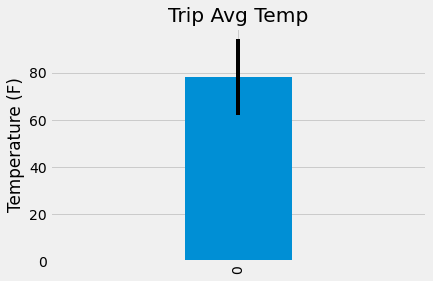

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps2015df['avg temp'].plot(kind='bar', width=0.2, yerr=(temps2015df['max temp']-temps2015df['min temp']))
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.show()

### Daily Rainfall Average

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount

rainfall = session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= '2015-08-01').filter(Measurement.date <= '2015-08-07').order_by(Measurement.prcp.desc()).group_by(Measurement.station).all()

precipdf = pd.DataFrame(rainfall, columns=['Station', 'Precipitation'])

print(precipdf)


       Station  Precipitation
0  USC00516128           1.75
1  USC00519523           0.40
2  USC00513117           0.68
3  USC00519397           0.26
4  USC00519281           0.53
5  USC00517948           0.05
6  USC00511918           0.10


In [49]:
# Get the station data to merge to the rainfall data
stationData = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()

stationdf = pd.DataFrame(stationData, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

print(stationdf)

       Station                                    Name  Latitude  Longitude  \
0  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   
1  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
2  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
3  USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   
4  USC00518838              UPPER WAHIAWA 874.3, HI US  21.49920 -158.01110   
5  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
6  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
7  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520 -157.99920   
8  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   

   Elevation  
0        3.0  
1       14.6  
2        7.0  
3       11.9  
4      306.6  
5       19.5  
6       32.9  
7        0.9  
8      152.4  


In [54]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stationRainfall = pd.merge(precipdf, stationdf, on="Station")
print(stationRainfall.sort_values('Precipitation', ascending=False))

       Station  Precipitation                                Name  Latitude  \
0  USC00516128           1.75        MANOA LYON ARBO 785.2, HI US  21.33310   
2  USC00513117           0.68                KANEOHE 838.1, HI US  21.42340   
4  USC00519281           0.53                 WAIHEE 837.5, HI US  21.45167   
1  USC00519523           0.40  WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
3  USC00519397           0.26                WAIKIKI 717.2, HI US  21.27160   
6  USC00511918           0.10   HONOLULU OBSERVATORY 702.2, HI US  21.31520   
5  USC00517948           0.05                   PEARL CITY, HI US  21.39340   

   Longitude  Elevation  
0 -157.80250      152.4  
2 -157.80150       14.6  
4 -157.84889       32.9  
1 -157.71139       19.5  
3 -157.81680        3.0  
6 -157.99920        0.9  
5 -157.97510       11.9  


### Daily Temperature Normals

In [67]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("08-01")

[('2014-08-01', 67.0, 75.54, 83.0)]

In [68]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start_date = '2015-08-01'
end_date = '2015-08-07'

# Use the start and end date to create a range of dates
daterangedf = pd.DataFrame(pd.date_range(start_date, end_date))

# Strip off the year and save a list of strings in the format %m-%d
daterange = daterangedf[0].dt.strftime('%m-%d')
print(daterange)


0    08-01
1    08-02
2    08-03
3    08-04
4    08-05
5    08-06
6    08-07
Name: 0, dtype: object


In [79]:

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for row in daterange:
    normals.append(daily_normals(row)[0])

print(normals)

[('2014-08-01', 67.0, 75.54, 83.0), ('2015-08-02', 68.0, 75.60377358490567, 84.0), ('2015-08-03', 70.0, 76.61111111111111, 85.0), ('2015-08-04', 69.0, 76.71153846153847, 84.0), ('2015-08-05', 69.0, 76.14814814814815, 82.0), ('2017-08-06', 67.0, 76.25, 83.0), ('2016-08-07', 71.0, 77.15686274509804, 83.0)]


In [92]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# normalsdf = pd.DataFrame(normals)
normalsdf = pd.DataFrame(normals, columns=['date', 'min temp', 'avg temp', 'max temp'])
normalsdf['date'] = pd.to_datetime(normalsdf['date'])
normalsdf['date'] = normalsdf['date'].dt.strftime('%m-%d')
normalsdf.set_index('date', inplace=True)
print(normalsdf)

       min temp   avg temp  max temp
date                                
08-01      67.0  75.540000      83.0
08-02      68.0  75.603774      84.0
08-03      70.0  76.611111      85.0
08-04      69.0  76.711538      84.0
08-05      69.0  76.148148      82.0
08-06      67.0  76.250000      83.0
08-07      71.0  77.156863      83.0


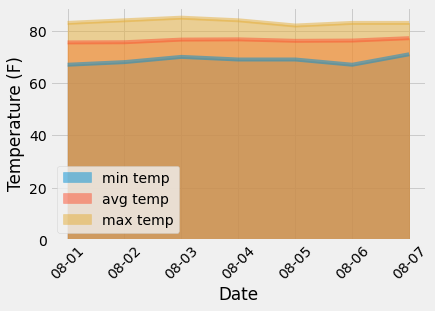

In [93]:
# Plot the daily normals as an area plot with `stacked=False`
normalsdf.plot(kind="area", stacked=False, rot=45)
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.show()

## Close Session

In [94]:
session.close()